# Taxi-week 3.
## Прогнозирование ряда со сложной сезонностью

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import datetime

In [2]:
import warnings
warnings.simplefilter(action='ignore')

## Загрузка данных
Загрузите все подготовленные данные о количестве поездок в Желтом такси и объедините в один датасет все, кроме данных за последний имеющийся месяц — июнь 2016.

In [3]:
df_6=pd.read_csv("taxi_2016_06.csv")
df_5=pd.read_csv("taxi_2016_05.csv")
df_3=pd.read_csv("taxi_2016_03.csv")
df_4=pd.read_csv("taxi_2016_04.csv")
df_2=pd.read_csv("taxi_2016_02.csv")
df_1=pd.read_csv("taxi_2016_01.csv")

In [4]:
df=pd.concat([ df_1,df_2,df_3,df_4,df_5], axis=0)

In [5]:
df.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])

In [7]:
min_ = 0
index = 0
for column in df.columns[1:]:
    if min_ < (df[column] != 0).sum():
        index = column
        min_ = (df[column] != 0).sum()

In [8]:
index

'1332'

###  👹Задание 1
- Выберите район, для которого вы хотите строить прогноз. Не забудьте, что нумерация районов идет с 1.
- Создайте датасет, в который поместите только информацию о времени (индексы строк) и числе поездок из выбранного района-единственный столбец
- Постройте график исходного ряда. Если видны какие-то аномалии, отметьте это.

Здесь и далее для работы с временными рядами можете пользоваться кодом из ноутбука с семинара 17. https://drive.google.com/file/d/1pOIUdenRSEje-iD1SVnFCItEdSIaeRui/view?usp=sharing


In [9]:
# Ваш кода  - создание датасета
chosen_area=1332
dataframe = pd.DataFrame(columns=[f'area {chosen_area}'])
dataframe[f'area {chosen_area}'] = df[f'{chosen_area}']
dataframe.index = df['Unnamed: 0']

In [10]:
# Ваш код- построение графика
def plot_df(x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(25,10), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

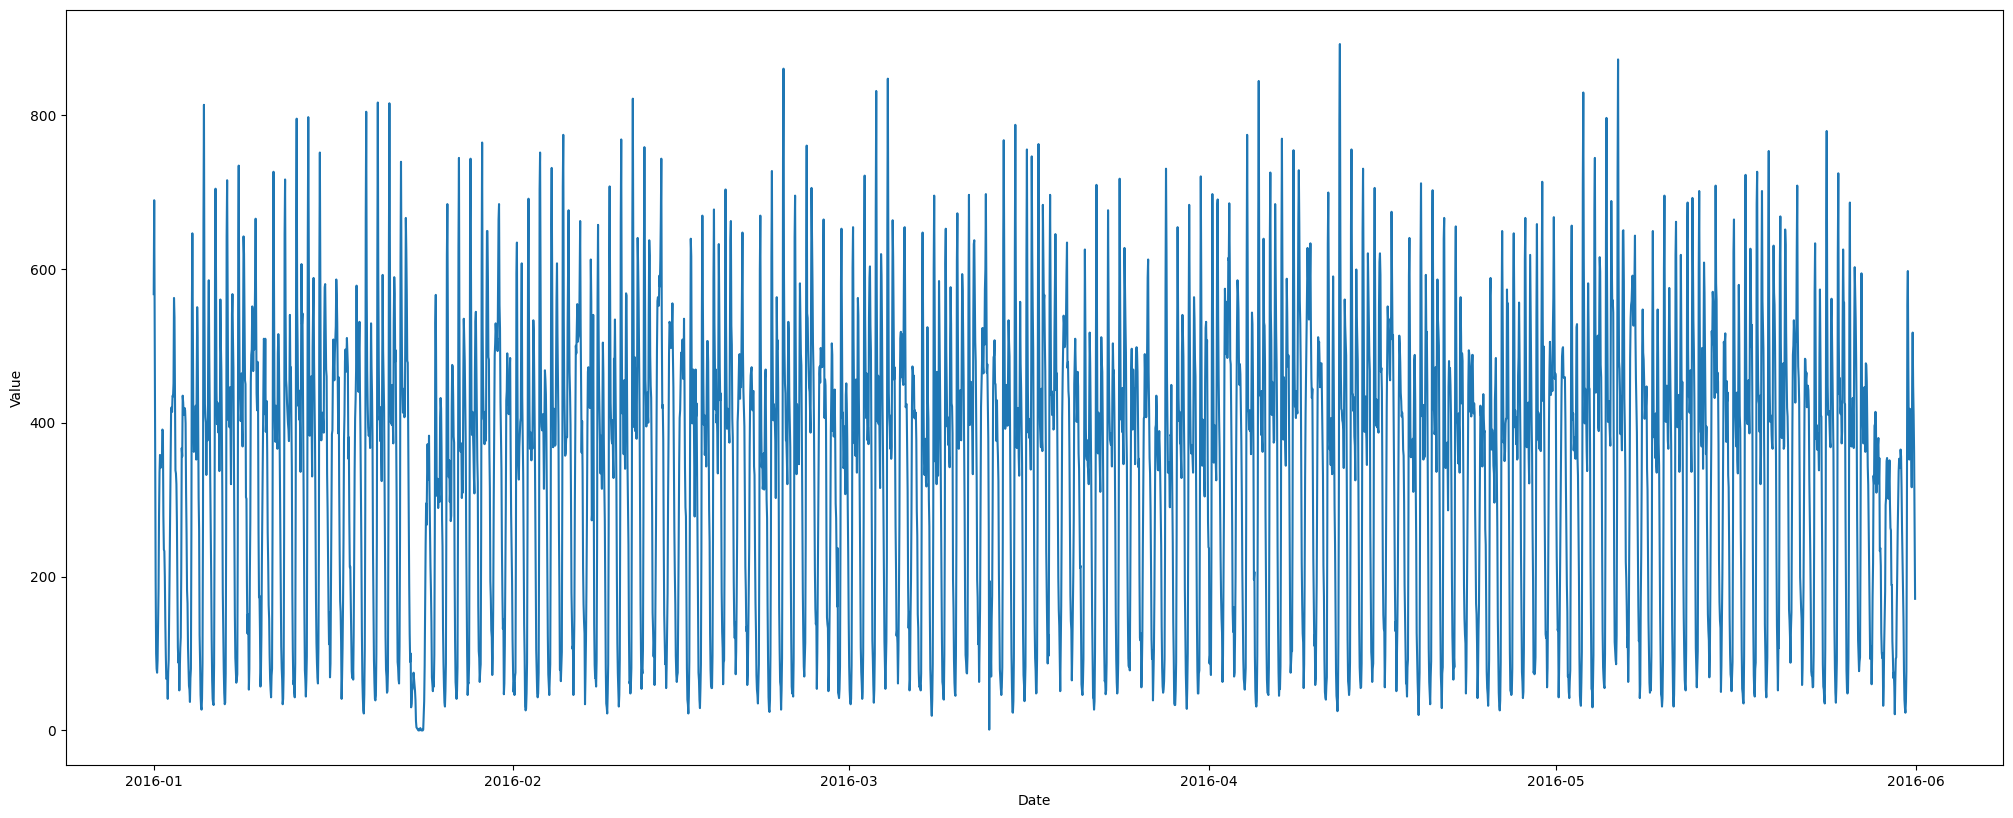

In [11]:
plot_df(dataframe.index, dataframe[f'area {chosen_area}'])

###  👹Задание 2
Проверьте ряд на стационарность:
- Произведите декомпозицию ряда`sm.tsa.seasonal_decompose()`
- Используйте критерий Дики-Фуллера
- Напишите выводы о наличии/отсутствии стационарности

<Figure size 720x504 with 0 Axes>

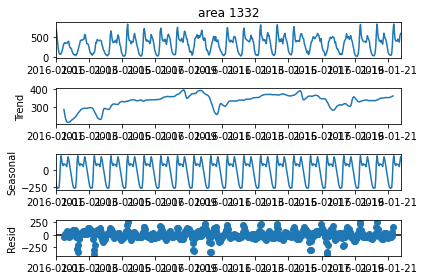

In [12]:
# Ваш код
plt.figure(figsize=(10,7))
sm.tsa.seasonal_decompose(dataframe[f'area {chosen_area}'][0:500], period=24).plot()
plt.show()

## Конструирование признаков

###  👹Задание 3

Создайте регрессионные признаки для учёта сезонностей и трендов.
- Для учета недельной сезонности, добавьте в датасет признаки - компоненты ряда Фурье 
$$\sin{\frac{2\pi\cdot i\cdot t}{w}}, \quad  \cos{\frac{2\pi\cdot i\cdot t}{w}}, \; i=1..K$$

    Число $K$ выберите сами - начните с небольшого значения (2-5), $w$ - длительность периода в часах (например, длительность недели в часах=168)
- Годовую сезонность мы учесть не можем, т.к. данные у нас всего за 5 месяцев.
- Если ранее при декомпозиции вы увидели тренд - добавьте также признаки для его учета (это может быть $t$, $t^2$,...)
- Обучим регрессионную модель, включающую созданные признаки. Посмотрим, насколько хорошо этой моделью объясняется дисперсия.
- **Замечание:** обратите внимание на то, что в модель очень желательно включить константу - иначе прогноз может оказаться смещенным. 

In [13]:
# Ваш код
test_df = dataframe.copy()
w = 168
t = np.arange(1, dataframe.shape[0]+1)
test_df['constant'] = np.ones(test_df.shape[0])
for i in range(1, 41):
    sin='s'+str(i)
    cos='c'+str(i)
    test_df[sin] = np.sin(2*np.pi*t*i/w)
    test_df[cos] = np.cos(2*np.pi*t*i/w)

In [14]:
test_df.head(20)

,area 1332,constant,s1,c1,s2,c2,s3,c3,s4,c4,...,s36,c36,s37,c37,s38,c38,s39,c39,s40,c40
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,567.0,1.0,0.037391,0.999301,0.074730,0.997204,0.111964,9.937122e-01,0.149042,0.988831,...,9.749279e-01,0.222521,0.982566,0.185912,0.988831,0.149042,0.993712,1.119645e-01,0.997204,0.074730
2016-01-01 01:00:00,689.0,1.0,0.074730,0.997204,0.149042,0.988831,0.222521,9.749279e-01,0.294755,0.955573,...,4.338837e-01,-0.900969,0.365341,-0.930874,0.294755,-0.955573,0.222521,-9.749279e-01,0.149042,-0.988831
2016-01-01 02:00:00,538.0,1.0,0.111964,0.993712,0.222521,0.974928,0.330279,9.438833e-01,0.433884,0.900969,...,-7.818315e-01,-0.623490,-0.846724,-0.532032,-0.900969,-0.433884,-0.943883,-3.302791e-01,-0.974928,-0.222521
2016-01-01 03:00:00,363.0,1.0,0.149042,0.988831,0.294755,0.955573,0.433884,9.009689e-01,0.563320,0.826239,...,-7.818315e-01,0.623490,-0.680173,0.733052,-0.563320,0.826239,-0.433884,9.009689e-01,-0.294755,0.955573
2016-01-01 04:00:00,194.0,1.0,0.185912,0.982566,0.365341,0.930874,0.532032,8.467242e-01,0.680173,0.733052,...,4.338837e-01,0.900969,0.593820,0.804598,0.733052,0.680173,0.846724,5.320321e-01,0.930874,0.365341
2016-01-01 05:00:00,100.0,1.0,0.222521,0.974928,0.433884,0.900969,0.623490,7.818315e-01,0.781831,0.623490,...,9.749279e-01,-0.222521,0.900969,-0.433884,0.781831,-0.623490,0.623490,-7.818315e-01,0.433884,-0.900969
2016-01-01 06:00:00,80.0,1.0,0.258819,0.965926,0.500000,0.866025,0.707107,7.071068e-01,0.866025,0.500000,...,3.673940e-16,-1.000000,-0.258819,-0.965926,-0.500000,-0.866025,-0.707107,-7.071068e-01,-0.866025,-0.500000
2016-01-01 07:00:00,75.0,1.0,0.294755,0.955573,0.563320,0.826239,0.781831,6.234898e-01,0.930874,0.365341,...,-9.749279e-01,-0.222521,-0.997204,0.074730,-0.930874,0.365341,-0.781831,6.234898e-01,-0.563320,0.826239
2016-01-01 08:00:00,91.0,1.0,0.330279,0.943883,0.623490,0.781831,0.846724,5.320321e-01,0.974928,0.222521,...,-4.338837e-01,0.900969,-0.111964,0.993712,0.222521,0.974928,0.532032,8.467242e-01,0.781831,0.623490


In [15]:
model = sm.OLS(test_df[f'area {chosen_area}'], test_df.drop([f'area {chosen_area}'], axis=1))

In [16]:
result = model.fit()

In [17]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              area 1332   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     362.5
Date:                Tue, 12 Apr 2022   Prob (F-statistic):               0.00
Time:                        16:42:41   Log-Likelihood:                -20238.
No. Observations:                3648   AIC:                         4.064e+04
Df Residuals:                    3567   BIC:                         4.114e+04
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant     341.2492      1.040    328.088      0.000     339.210     343.288
s1            -5.0310      1.472     -3.418      0.001      -7.917      -2.145
c1            34.8138      1.470     23.684      0.000      31.932      37.696
s2            11.3937      1.470      7.752      0.000       8.512      14.276
c2            -4.4921      1.472     -3.052      0.002      -7.378      -1.606
s3            -6.0870      1.472     -4.136      0.000      -8.972      -3.201
c3             1.9074      1.470      1.297      0.195      -0.975       4.790
s4             4.6631      1.470      3.172      0.002       1.781       7.546
c4            10.7202      1.472      7.284      0.000       7.835      13.606
s5            14.7074      1.471      9.996      0.000      11.823      17.592
c5           -11.5417      1.471     -7.849      0.000     -14.425      -8.658
s6           -30.7490      1.471    -20.910      0.000     -33.632     -27.866
c6            -9.2778      1.471     -6.306      0.000     -12.163      -6.393
s7          -138.2528      1.471    -93.989      0.000    -141.137    -135.369
c7          -101.9590      1.471    -69.315      0.000    -104.843     -99.075
s8            22.5525      1.471     15.333      0.000      19.669      25.436
c8            37.5551      1.471     25.530      0.000      34.671      40.439
s9            18.4449      1.471     12.542      0.000      15.561      21.328
c9           -14.9900      1.471    -10.189      0.000     -17.874     -12.105
s10           -6.3665      1.471     -4.328      0.000      -9.251      -3.482
c10           -3.0096      1.471     -2.046      0.041      -5.893      -0.126
s11            7.5463      1.471      5.132      0.000       4.663      10.430
c11            1.0761      1.471      0.731      0.465      -1.809       3.961
s12          -14.7009      1.471     -9.993      0.000     -17.585     -11.817
c12          -20.4411      1.471    -13.898      0.000     -23.325     -17.557
s13          -28.3136      1.471    -19.252      0.000     -31.197     -25.430
c13           46.3914      1.471     31.533      0.000      43.507      49.276
s14         -124.3140      1.471    -84.513      0.000    -127.198    -121.430
c14           19.8989      1.471     13.528      0.000      17.015      22.783
s15           -0.1234      1.471     -0.084      0.933      -3.007       2.760
c15          -35.0932      1.471    -23.856      0.000     -37.977     -32.209
s16          -15.7527      1.471    -10.710      0.000     -18.636     -12.869
c16            1.3894      1.471      0.944      0.345      -1.495       4.274
s17            1.7756      1.471      1.207      0.227      -1.108       4.660
c17            3.7494      1.471      2.549      0.011       0.865       6.633
s18           -5.4355      1.471     -3.696      0.000      -8.319      -2.552
c1

###  👹Задание 4
1. Составьте временные ряды:
- из остатков регрессионной модели
- из продифференцированных остатков модели (обычное и/или сезонное дифференцирование)
2. Произведите декомпозиции этих рядов, примените критерий Дики-Фуллера и проверьте получившиеся ряды на стационарность

In [18]:
# Ваш код
resid = pd.DataFrame(result.resid, columns={'resid'})

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1152x720 with 0 Axes>

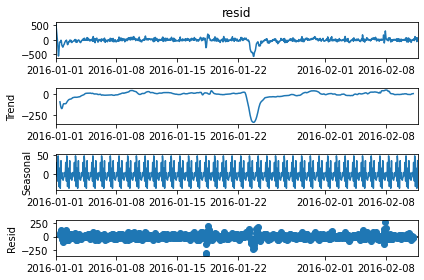

In [19]:
plt.figure(figsize=(16,10))
sm.tsa.seasonal_decompose(resid.resid[:1000]).plot()
plt.show

In [20]:
print(f"Adfuler criteria (p-value): {adfuller(resid.resid)[1]}")

Adfuler criteria (p-value): 5.310377148893172e-11


## Residuals seasonal decompose

In [21]:
resid['resid_D24'] = resid.resid - resid.resid.shift(24)

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1152x720 with 0 Axes>

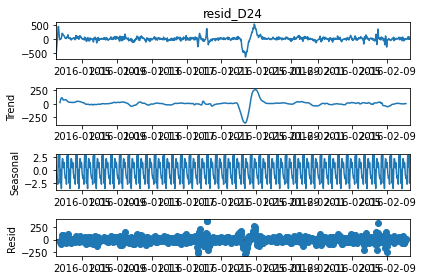

In [22]:
plt.figure(figsize=(16,10))
sm.tsa.seasonal_decompose(resid['resid_D24'][24:1000]).plot()
plt.show

In [23]:
print(f"Adfuler criteria (p-value): {adfuller(resid['resid_D24'][24:])[1]}")

Adfuler criteria (p-value): 1.3900479220145381e-24


## Resideuals additional simple differentiation decompose

In [24]:
resid['resid_D24_d1'] = resid['resid_D24'] - resid['resid_D24'].shift(1)

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1152x720 with 0 Axes>

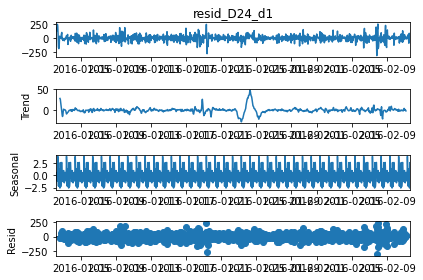

In [25]:
plt.figure(figsize=(16,10))
sm.tsa.seasonal_decompose(resid['resid_D24_d1'][25:1000]).plot()
plt.show

In [26]:
print(f"Adfuler criteria (p-value): {adfuller(resid['resid_D24_d1'][25:])[1]}")

Adfuler criteria (p-value): 3.676042771199876e-30


##  Подбор параметров моделей SARMA и SARIMA

**Всюду далее будем работать только рядом из остатков (т.е будем конструировать модель SARMA).**

**Если вы решите работать c продифференцированными остатками (и конструировать модель SARIMA), то эту работу проведите дома самостоятельно.**

###  👹Задание 5
С помощью  `statsmodels.api.graphics.tsa.plot_acf` и `statsmodels.api.graphics.tsa.plot_pacf` по автокорреляции и частичной автокорреляции подберите параметры модели ARMA - p,q,P,Q. 

**Замечание:** имейте в виду, что при выборе больших значений параметров модель будет весьма долго обучаться. 

## Seasonally differentiated residuals

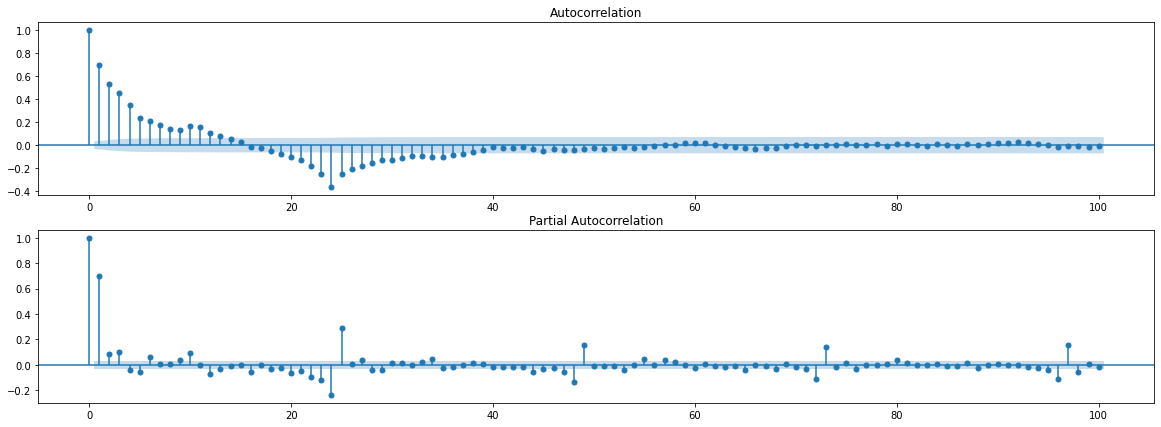

In [27]:
plt.figure(figsize=(20, 7)) 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid['resid_D24'][24:].values.squeeze(), lags=100, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid['resid_D24'][24:].values.squeeze(), lags=100, ax=ax)
plt.show()

## Residuals

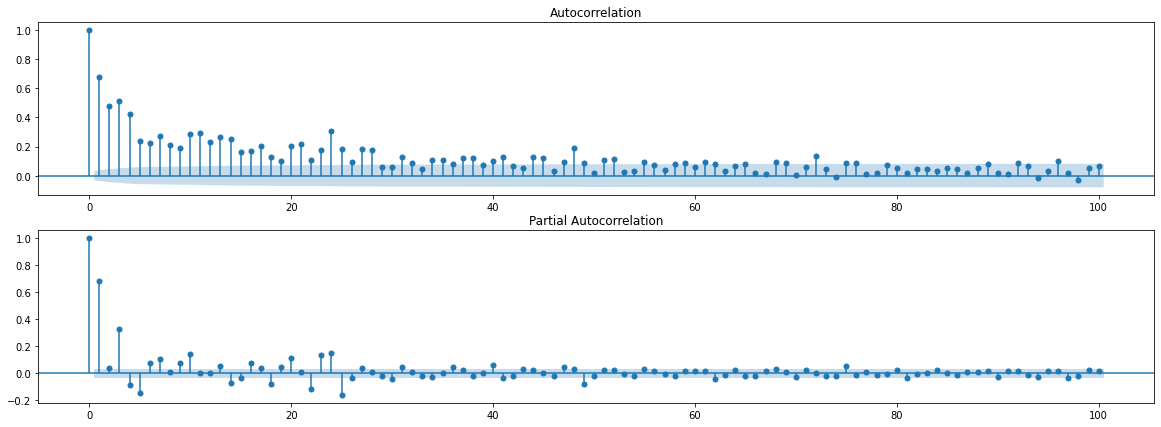

In [28]:
plt.figure(figsize=(20, 7)) 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid.resid.values.squeeze(), lags=100, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid.resid.values.squeeze(), lags=100, ax=ax)
plt.show()

## Seasonal and simple differentiation

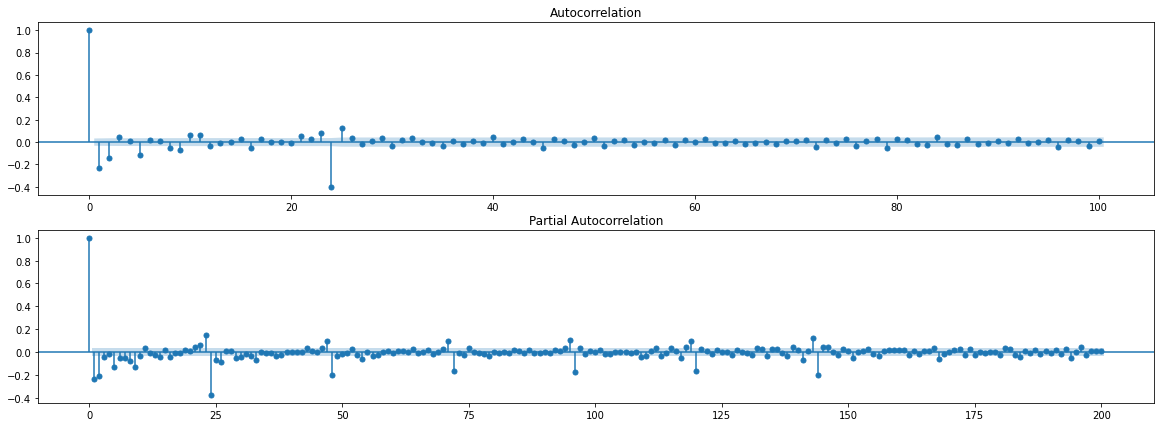

In [29]:
plt.figure(figsize=(20, 7)) 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid['resid_D24_d1'][25:].values.squeeze(), lags=100, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid['resid_D24_d1'][25:].values.squeeze(), lags=200, ax=ax)
plt.show()

Работать будем с остатками, продиференцированными обычно и по сезону
Для них параметры: Q=1 , q=5, P=1 , p=5

## Параметры модели подобраны для ряда без сезонного дифференцирования

##  Обучение моделей и проверка качества прогноза  

Определим функцию, которая будет строить модели SARIMA с помощью функции SARIMAX для разных значений параметров p,q,P,Q (по сетке) и выбирать наилучшую по метрике aic. Источник https://gist.github.com/JessicaFB/af4c9d12ec8314cff56b5e0f18b8e61c

In [30]:
def sarimax_gridsearch(ts, exog, par, d=1, D=1, s=24, maxiter=50, freq='H'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best AIC value
    ans = []
    for comb in par:
        try:
            #print("ahahah")
            model = sm.tsa.statespace.SARIMAX(ts, exog,
                                                order=(comb[0],d,comb[1]),
                                                seasonal_order=(comb[2],D, comb[3],s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)
            #print("ohoho")
            output = model.fit(maxiter=maxiter, method='nm', disp=-1)#, low_memory=True) 
            #print("sg")
            ans.append([comb,output.aic])
            print('SARIMAX {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue
            
    # Find the parameters with minimal AIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pqPQ', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:10]
    
    return ans_df

В качестве максимальных значений для p, q, P, Q вставьть те, которые подобрали ранее по графикам автокорреляции и частичной автокорреляции
В качестве параметров `exog` вам необходимо брать все те регрессионные признаки, которые вы добавили в модель.

In [31]:
# 
Q = range(0, 1)
q = range(0, 5)
P = range(0, 1)
p = range(0, 5)
D=0
d=0
s=24
ex=test_df.drop([f'area {chosen_area}'], axis=1)

In [32]:
from itertools import product
parameters = list(product(p, q, P, Q))
len(parameters)

25

**Совет:** если длина списка параметров у вас получится большая, то для начала передайте в функцию  `sarimax_gridsearch` только начало списка (например, первые 4 элемента) и оцените, насколько быстро у вас отрабатывает функция. Если дольше 2 минут, то оставьте перебор по всему списку параметров на дом.

In [33]:
%%time
sarimax_gridsearch(test_df[f'area {chosen_area}'],ex, parameters, freq='H')

Wall time: 5min 8s


,pqPQ,aic
20,"(4, 0, 0, 0)",3.878568e+04
15,"(3, 0, 0, 0)",3.881565e+04
10,"(2, 0, 0, 0)",3.884559e+04
5,"(1, 0, 0, 0)",3.901759e+04
0,"(0, 0, 0, 0)",6.452077e+04
21,"(4, 1, 0, 0)",3.361873e+13
16,"(3, 1, 0, 0)",8.334844e+13
1,"(0, 1, 0, 0)",4.848638e+14
9,"(1, 4, 0, 0)",1.960481e+15
14,"(2, 4, 0, 0)",2.090310e+15


###  👹Задание 6
- Выберите оптимальную по AIC модель, обучите ее.
- На одном графике изобразите исходный ряд за 5 месяцев и прогнозные значения, получаемые с помощью модели.
- Проведите численную оценку качества с помощью одной из регрессионных метрик (MSE, MAE, MAPE...). 
    При этом имейте в виду, что не стоит опираться на несколько первых значений остатков модели, они считаются "ненадежными"  и обычно исключаются при оценке качества.
    Номер первого "надежного" остатка вычисляется по формуле:

$$\max{\{(P+D)s+p+d, Qs+q}\}$$

In [34]:
test_df

,area 1332,constant,s1,c1,s2,c2,s3,c3,s4,c4,...,s26,c26,s27,c27,s28,c28,s29,c29,s30,c30
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,567.0,1.0,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,...,0.826239,0.563320,0.846724,0.532032,8.660254e-01,0.5,0.884115,0.467269,0.900969,4.338837e-01
2016-01-01 01:00:00,689.0,1.0,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,...,0.930874,-0.365341,0.900969,-0.433884,8.660254e-01,-0.5,0.826239,-0.563320,0.781831,-6.234898e-01
2016-01-01 02:00:00,538.0,1.0,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,...,0.222521,-0.974928,0.111964,-0.993712,1.224647e-16,-1.0,-0.111964,-0.993712,-0.222521,-9.749279e-01
2016-01-01 03:00:00,363.0,1.0,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,...,-0.680173,-0.733052,-0.781831,-0.623490,-8.660254e-01,-0.5,-0.930874,-0.365341,-0.974928,-2.225209e-01
2016-01-01 04:00:00,194.0,1.0,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,...,-0.988831,0.149042,-0.943883,0.330279,-8.660254e-01,0.5,-0.757972,0.652287,-0.623490,7.818315e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-31 19:00:00,448.0,1.0,-0.930874,-0.365341,0.680173,-0.733052,0.433884,0.900969,-0.997204,0.074730,...,-0.294755,0.955573,-0.781831,-0.623490,8.660254e-01,-0.5,0.149042,0.988831,-0.974928,-2.225209e-01
2016-05-31 20:00:00,410.0,1.0,-0.943883,-0.330279,0.623490,-0.781831,0.532032,0.846724,-0.974928,0.222521,...,0.623490,0.781831,-0.943883,0.330279,-2.029241e-13,-1.0,0.943883,0.330279,-0.623490,7.818315e-01
2016-05-31 21:00:00,360.0,1.0,-0.955573,-0.294755,0.563320,-0.826239,0.623490,0.781831,-0.930874,0.365341,...,0.997204,-0.074730,-0.222521,0.974928,-8.660254e-01,-0.5,0.733052,-0.680173,0.433884,9.009689e-01


In [41]:
p=4
P=0
Q=0
q=0
D=0
d=0
s=24
ex=test_df.drop([f'area {chosen_area}'], axis=1)
mod = sm.tsa.statespace.SARIMAX(test_df[f'area {chosen_area}'],exog=ex, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)

In [42]:
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:              area 1332   No. Observations:                 3648
Model:               SARIMAX(4, 0, 0)   Log Likelihood              -18810.334
Date:                Tue, 12 Apr 2022   AIC                          37792.669
Time:                        16:55:56   BIC                          38325.941
Sample:                    01-01-2016   HQIC                         37982.597
                         - 05-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant     340.5656      3.924     86.789      0.000     332.875     348.257
s1            -5.1604      5.489     -0.940      0.347     -15.919       5.598
c1            34.0926      5.381      6.335      0.0

In [43]:
predictions = mod.get_prediction(start=datetime.datetime.strptime("2016-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"), 
                                         end=datetime.datetime.strptime("2016-05-31 23:00:00", "%Y-%m-%d %H:%M:%S"), 
                                         dynamic=False,  exog=ex)

In [44]:
def build_plot(real_values, predictions):
    plt.figure(figsize=(20,5))
    plt.plot(real_values.index[3000:], real_values[f'area {chosen_area}'][3000:], color='green')
    plt.plot(real_values.index[3000:], predictions.predicted_mean.values[3000:], color='red')
    plt.legend(['Real values', 'SARIMAX predictions'])
    plt.title('Real number of taxi calls and SARIMAX predictions comparison')
    plt.ylabel('Number of taxi calls')
    plt.xlabel('Date')
    plt.show()

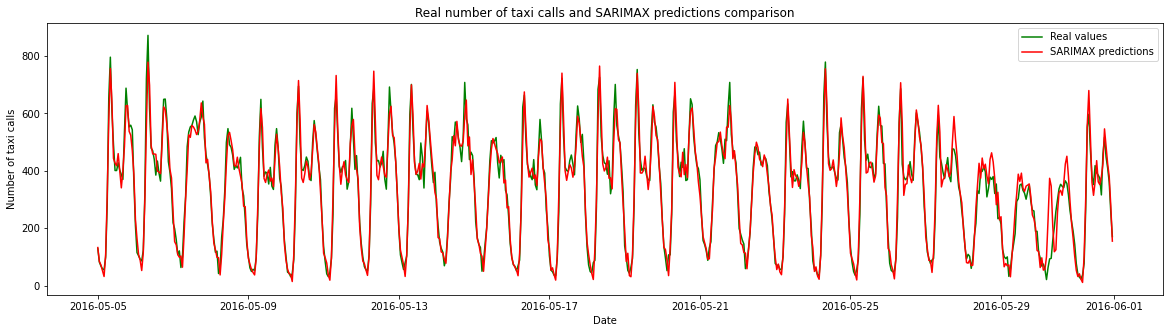

In [45]:
# Ваш код - построение графиков
build_plot(test_df, predictions)

In [46]:
# импортируете функций вычисления регрессионных метрик
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score  

In [47]:
# Ваш код - вычисление метрик
print(f"MAE for SARIMAX model is: {mean_absolute_error(test_df[f'area {chosen_area}'], predictions.predicted_mean.values)}")

MAE for SARIMAX model is: 31.030173980223857


## Такой результат MAE может быть вызван аномальным поведением модели при предсказании количества поездок в конце мая-начале июня (третье дно, считая с конца). В остальном, модель ведет себя очень достойно на всем исследованном периоде. В некоторых местах можно заметить, что из-за своей общей негибкости модель "боится" делать смелый прогноз и сглаживает ожидаемые значения.

## Прогнозирование на новых данных

###  👹Задание 7
- Создайте расширенный датасет,объединив данные за все 6 месяцев. Вычислите и занесите в этот датасет значения всех выделенных в Задании 3 признаков.
- Получите прогноз на январь-июнь 2016, также можно (при желании) вычислить доверительные интервалы для прогнозных значений.
- Отобразите на графике истинные значения ряда за январь-июнь, прогнозные значения и, при желании доверительные интервалы для прогнозных значений. Для отрисовки доверительных интервалов пригодится код:

    `plt.fill_between(my_timeseries, ci.iloc[:,0].values, ci.iloc[:,1].values, color='r', alpha=0.1)`
- Вычислите значения регрессионных метрик качества из Задания 6 на данных за июнь


In [53]:
# Ваш код - создание датасета
df_new=pd.concat([ df_1,df_2,df_3,df_4,df_5,df_6], axis=0)
df_new['Unnamed: 0'] = pd.to_datetime(df_new['Unnamed: 0'])
chosen_area=1332
dataframe = pd.DataFrame(columns=[f'area {chosen_area}'])
dataframe[f'area {chosen_area}'] = df_new[f'{chosen_area}']
dataframe.index = df_new['Unnamed: 0']
test_df_new = dataframe.copy()
w = 168
t = np.arange(1, dataframe.shape[0]+1)
test_df_new['constant'] = np.ones(test_df_new.shape[0])
for i in range(1, 41):
    sin='s'+str(i)
    cos='c'+str(i)
    test_df_new[sin] = np.sin(2*np.pi*t*i/w)
    test_df_new[cos] = np.cos(2*np.pi*t*i/w)

In [54]:
test_df_new

,area 1332,constant,s1,c1,s2,c2,s3,c3,s4,c4,...,s36,c36,s37,c37,s38,c38,s39,c39,s40,c40
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,567.0,1.0,3.739119e-02,0.999301,7.473009e-02,0.997204,1.119645e-01,0.993712,1.490423e-01,0.988831,...,9.749279e-01,0.222521,9.825665e-01,0.185912,9.888308e-01,0.149042,9.937122e-01,0.111964,9.972038e-01,0.074730
2016-01-01 01:00:00,689.0,1.0,7.473009e-02,0.997204,1.490423e-01,0.988831,2.225209e-01,0.974928,2.947552e-01,0.955573,...,4.338837e-01,-0.900969,3.653410e-01,-0.930874,2.947552e-01,-0.955573,2.225209e-01,-0.974928,1.490423e-01,-0.988831
2016-01-01 02:00:00,538.0,1.0,1.119645e-01,0.993712,2.225209e-01,0.974928,3.302791e-01,0.943883,4.338837e-01,0.900969,...,-7.818315e-01,-0.623490,-8.467242e-01,-0.532032,-9.009689e-01,-0.433884,-9.438833e-01,-0.330279,-9.749279e-01,-0.222521
2016-01-01 03:00:00,363.0,1.0,1.490423e-01,0.988831,2.947552e-01,0.955573,4.338837e-01,0.900969,5.633201e-01,0.826239,...,-7.818315e-01,0.623490,-6.801727e-01,0.733052,-5.633201e-01,0.826239,-4.338837e-01,0.900969,-2.947552e-01,0.955573
2016-01-01 04:00:00,194.0,1.0,1.859116e-01,0.982566,3.653410e-01,0.930874,5.320321e-01,0.846724,6.801727e-01,0.733052,...,4.338837e-01,0.900969,5.938202e-01,0.804598,7.330519e-01,0.680173,8.467242e-01,0.532032,9.308737e-01,0.365341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,501.0,1.0,-1.490423e-01,0.988831,-2.947552e-01,0.955573,-4.338837e-01,0.900969,-5.633201e-01,0.826239,...,7.818315e-01,0.623490,6.801727e-01,0.733052,5.633201e-01,0.826239,4.338837e-01,0.900969,2.947552e-01,0.955573
2016-06-30 20:00:00,451.0,1.0,-1.119645e-01,0.993712,-2.225209e-01,0.974928,-3.302791e-01,0.943883,-4.338837e-01,0.900969,...,7.818315e-01,-0.623490,8.467242e-01,-0.532032,9.009689e-01,-0.433884,9.438833e-01,-0.330279,9.749279e-01,-0.222521
2016-06-30 21:00:00,437.0,1.0,-7.473009e-02,0.997204,-1.490423e-01,0.988831,-2.225209e-01,0.974928,-2.947552e-01,0.955573,...,-4.338837e-01,-0.900969,-3.653410e-01,-0.930874,-2.947552e-01,-0.955573,-2.225209e-01,-0.974928,-1.490423e-01,-0.988831


In [55]:
ex = test_df_new.drop([f'area {chosen_area}'], axis=1)
ex

,constant,s1,c1,s2,c2,s3,c3,s4,c4,s5,...,s36,c36,s37,c37,s38,c38,s39,c39,s40,c40
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1.0,3.739119e-02,0.999301,7.473009e-02,0.997204,1.119645e-01,0.993712,1.490423e-01,0.988831,1.859116e-01,...,9.749279e-01,0.222521,9.825665e-01,0.185912,9.888308e-01,0.149042,9.937122e-01,0.111964,9.972038e-01,0.074730
2016-01-01 01:00:00,1.0,7.473009e-02,0.997204,1.490423e-01,0.988831,2.225209e-01,0.974928,2.947552e-01,0.955573,3.653410e-01,...,4.338837e-01,-0.900969,3.653410e-01,-0.930874,2.947552e-01,-0.955573,2.225209e-01,-0.974928,1.490423e-01,-0.988831
2016-01-01 02:00:00,1.0,1.119645e-01,0.993712,2.225209e-01,0.974928,3.302791e-01,0.943883,4.338837e-01,0.900969,5.320321e-01,...,-7.818315e-01,-0.623490,-8.467242e-01,-0.532032,-9.009689e-01,-0.433884,-9.438833e-01,-0.330279,-9.749279e-01,-0.222521
2016-01-01 03:00:00,1.0,1.490423e-01,0.988831,2.947552e-01,0.955573,4.338837e-01,0.900969,5.633201e-01,0.826239,6.801727e-01,...,-7.818315e-01,0.623490,-6.801727e-01,0.733052,-5.633201e-01,0.826239,-4.338837e-01,0.900969,-2.947552e-01,0.955573
2016-01-01 04:00:00,1.0,1.859116e-01,0.982566,3.653410e-01,0.930874,5.320321e-01,0.846724,6.801727e-01,0.733052,8.045978e-01,...,4.338837e-01,0.900969,5.938202e-01,0.804598,7.330519e-01,0.680173,8.467242e-01,0.532032,9.308737e-01,0.365341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,1.0,-1.490423e-01,0.988831,-2.947552e-01,0.955573,-4.338837e-01,0.900969,-5.633201e-01,0.826239,-6.801727e-01,...,7.818315e-01,0.623490,6.801727e-01,0.733052,5.633201e-01,0.826239,4.338837e-01,0.900969,2.947552e-01,0.955573
2016-06-30 20:00:00,1.0,-1.119645e-01,0.993712,-2.225209e-01,0.974928,-3.302791e-01,0.943883,-4.338837e-01,0.900969,-5.320321e-01,...,7.818315e-01,-0.623490,8.467242e-01,-0.532032,9.009689e-01,-0.433884,9.438833e-01,-0.330279,9.749279e-01,-0.222521
2016-06-30 21:00:00,1.0,-7.473009e-02,0.997204,-1.490423e-01,0.988831,-2.225209e-01,0.974928,-2.947552e-01,0.955573,-3.653410e-01,...,-4.338837e-01,-0.900969,-3.653410e-01,-0.930874,-2.947552e-01,-0.955573,-2.225209e-01,-0.974928,-1.490423e-01,-0.988831


In [56]:
ex = ex[ex.index >= pd.to_datetime('2016-06-01')]

In [57]:
predictions = mod.get_prediction(start=datetime.datetime.strptime("2016-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"), 
                                         end=datetime.datetime.strptime("2016-06-30 23:00:00", "%Y-%m-%d %H:%M:%S"), 
                                         dynamic=True,  exog=ex)
predict_conf_int = predictions.conf_int() # доверительные интервалы для прогнозов
ci=predict_conf_int.loc['2016-01-01':,]

In [58]:
# Ваш код - построение графика
def build_big_plot(real_values, predictions, ci):
    plt.figure(figsize=(20,5))
    plt.plot(real_values.index[3500:], real_values[f'area {chosen_area}'][3500:], color='green')
    plt.plot(real_values.index[3500:], predictions.predicted_mean.values[3500:], color='red')
    plt.fill_between(real_values.index[3500:], ci.iloc[:,0].values[3500:], ci.iloc[:,1].values[3500:], color='r', alpha=0.1)
    plt.legend(['Real values', 'SARIMAX predictions'])
    plt.title('Real number of taxi calls and SARIMAX predictions comparison until June')
    plt.ylabel('Number of taxi calls')
    plt.xlabel('Date')
    plt.show()

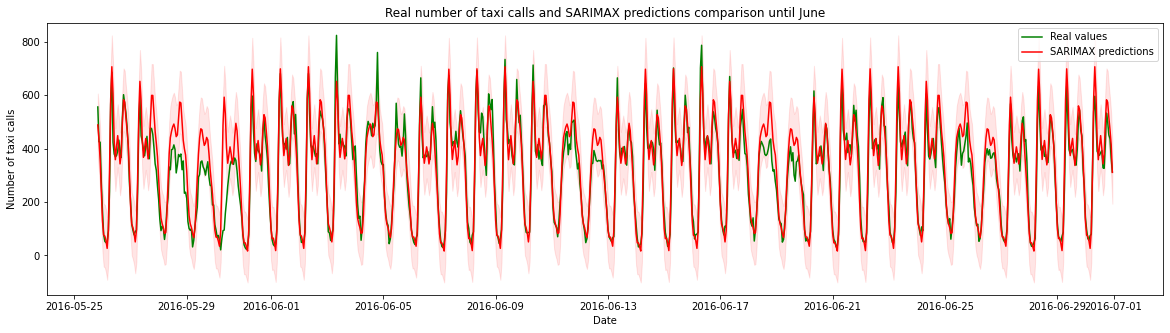

In [59]:
build_big_plot(test_df_new, predictions, ci)

In [60]:
# Ваш код - вычисление метрик качества
print(f"MAE for SARIMAX model is: {mean_absolute_error(test_df_new[f'area {chosen_area}'], predictions.predicted_mean.values)}")

MAE for SARIMAX model is: 38.18614396469373


## Выводы
###  👹Задание 8 и самое интересное
- Сделайте вывод о качестве прогноза модели, в т.ч. на новых данных
- Определите в какие даты прогноз модели сильно расходится с истинными значениями. С чем это может быть связано?
- Попробуйте добавить в модель регрессионные признаки: еще несколько компонент Фурье, индикаторы праздничных дней, индикаторы природных аномалий и др.
- Обучите модель заново и проведите аналогичный сделанному выше анализ. Улучшилось ли качество прогноза?

**Немного полезных ссылок:**
- Как добавить элементы ряда Фурье в качестве предикторов https://otexts.com/fpp2/useful-predictors.html
- SARIMAX  in Python  https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
- Holidays in Python 
https://towardsdatascience.com/5-minute-guide-to-detecting-holidays-in-python-c270f8479387
- Wheather events in New York
https://www.weather.gov/okx/stormevents
- Про то, на какие остатки модели не стоит обращать внимание https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_faq.html


## В качестве экмперимента попробуем добавить в датасет столбец, отвечающий за праздники в конкретный день (бинарная категориальная переменная, означающая наличие праздника в конкретную дату)

In [61]:
fest_days = ['2016-01-16',
            '2016-01-19',
            '2016-02-01',
            '2016-02-02',
            '2016-02-14',
            '2016-03-17',
            '2016-05-01',
            '2016-06-14']
fest_days = list(map(lambda x: pd.to_datetime(x), fest_days))
test_df['holidays'] = np.zeros(test_df.shape[0])

In [62]:
list_ = test_df['holidays']

In [63]:
list_[fest_days[0]:fest_days[1]]

Unnamed: 0
2016-01-16 00:00:00    0.0
2016-01-16 01:00:00    0.0
2016-01-16 02:00:00    0.0
2016-01-16 03:00:00    0.0
2016-01-16 04:00:00    0.0
                      ... 
2016-01-18 20:00:00    0.0
2016-01-18 21:00:00    0.0
2016-01-18 22:00:00    0.0
2016-01-18 23:00:00    0.0
2016-01-19 00:00:00    0.0
Name: holidays, Length: 73, dtype: float64

In [64]:
def make_holidays(test_df, dates):
    list_ = test_df['holidays']
    for date in dates:
        list_[date:date+pd.Timedelta(1,'d')] = 1
    return list_

In [65]:
test_df['holidays'] = make_holidays(test_df, fest_days)

In [66]:
test_df['holidays'][381:]

Unnamed: 0
2016-01-16 21:00:00    1.0
2016-01-16 22:00:00    1.0
2016-01-16 23:00:00    1.0
2016-01-17 00:00:00    1.0
2016-01-17 01:00:00    0.0
                      ... 
2016-05-31 19:00:00    0.0
2016-05-31 20:00:00    0.0
2016-05-31 21:00:00    0.0
2016-05-31 22:00:00    0.0
2016-05-31 23:00:00    0.0
Name: holidays, Length: 3267, dtype: float64

## Обучим SARIMAX модель

In [67]:
p=4
P=0
Q=0
q=0
D=0
d=0
s=24
ex=test_df.drop([f'area {chosen_area}'], axis=1)

mod = sm.tsa.statespace.SARIMAX(test_df[f'area {chosen_area}'],exog=ex, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)

In [68]:
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:              area 1332   No. Observations:                 3648
Model:               SARIMAX(4, 0, 0)   Log Likelihood              -18810.914
Date:                Tue, 12 Apr 2022   AIC                          37795.828
Time:                        16:58:45   BIC                          38335.300
Sample:                    01-01-2016   HQIC                         37987.965
                         - 05-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant     340.0529      3.935     86.413      0.000     332.340     347.766
s1            -5.2283      5.469     -0.956      0.339     -15.947       5.490
c1            34.3528      5.376      6.390      0.0

In [69]:
predictions = mod.get_prediction(start=datetime.datetime.strptime("2016-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"), 
                                         end=datetime.datetime.strptime("2016-05-31 23:00:00", "%Y-%m-%d %H:%M:%S"), 
                                         dynamic=False,  exog=ex)

In [70]:
def build_plot(real_values, predictions):
    plt.figure(figsize=(20,5))
    plt.plot(real_values.index[3000:], real_values[f'area {chosen_area}'][3000:], color='green')
    plt.plot(real_values.index[3000:], predictions.predicted_mean.values[3000:], color='red')
    plt.legend(['Real values', 'SARIMAX predictions'])
    plt.title('Real number of taxi calls and SARIMAX predictions comparison')
    plt.ylabel('Number of taxi calls')
    plt.xlabel('Date')
    plt.show()

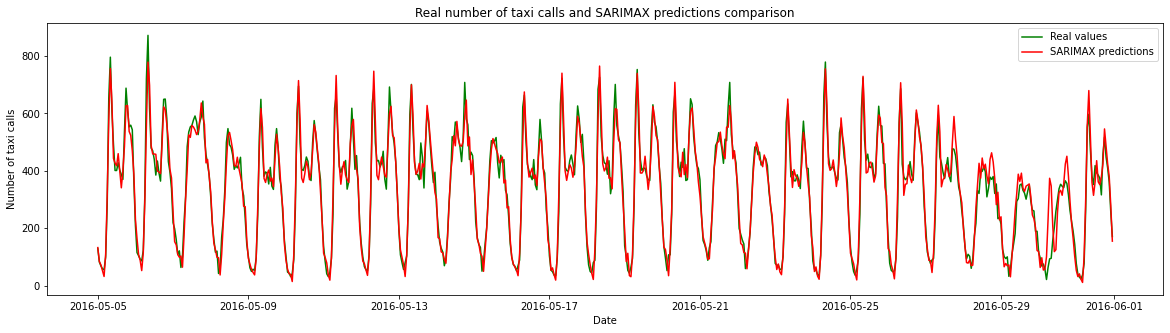

In [71]:
# Ваш код - построение графиков
build_plot(test_df, predictions)

In [72]:
# Ваш код - вычисление метрик
print(f"MAE for SARIMAX model is: {mean_absolute_error(test_df[f'area {chosen_area}'], predictions.predicted_mean.values)}")

MAE for SARIMAX model is: 31.0266542447582
